# Import libraries

In [2]:
import numpy as np
import pandas as pd 
import statsmodels as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.api import STLForecast
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from pylab import rcParams

from matplotlib import pyplot

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings("ignore")


import warnings
warnings.filterwarnings("ignore")

# Load dataset

In [4]:
user_balance=pd.read_csv('/Users/yupengshen/DA_portfolio/cashflow/cashflow_data/user_balance_table.csv')
user_balance['report_date'] = pd.to_datetime(user_balance['report_date'], format='%Y%m%d')

user_balance.sort_values(by='report_date', inplace=True)

data = user_balance.groupby(['report_date']).sum()


In [5]:
train_data = data.iloc[273:396]
train_data.head()


,user_id,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
report_date,,,,,,,,,,,,,,,,,
2014-03-31,135819687,20417009416,20441977145,398884905,396026448,154073551,241952897,423852634,48345100,375507534,56545010,318962524,2858457,15131526.0,19797628.0,210000.0,13205946.0
2014-04-01,136584390,20592900643,20417009416,453320585,450478122,146539591,303938531,277429358,49540539,227888819,37116613,190772206,2842463,16208162.0,13781112.0,280000.0,19271265.0
2014-04-02,137008542,20675635695,20592900643,355347118,352449616,141024158,211425458,272612066,51040952,221571114,28301147,193269967,2897502,16141646.0,21068826.0,200000.0,13630480.0
2014-04-03,137908818,20772907358,20675635695,363877120,360958034,165866758,195091276,266605457,45762040,220843417,46915541,173927876,2919086,12047671.0,14437186.0,380000.0,18897183.0
2014-04-04,137746345,20824610615,20772907358,251895894,248968008,62838487,186129521,200192637,37871189,162321448,35154471,127166977,2927886,14199433.0,12740751.0,1000000.0,9931005.0


In [6]:
test_data = data.iloc[396:427]
test_data.head()

,user_id,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
report_date,,,,,,,,,,,,,,,,,
2014-08-01,170153578,20069760015,19947416138,374884735,372678958,135715324,236963634,252540858,84227601,168313257,31013339,137299918,2205777,32731901.0,29456809.0,5100000.0,16938891.0
2014-08-02,169838291,20086601920,20069760015,189092130,186889349,78478704,108410645,172250225,41930977,130319248,34359098,95960150,2202781,20388807.0,7149562.0,0.0,14392608.0
2014-08-03,170475856,20133302100,20086601920,173825397,171634865,62120575,109514290,127125217,40828571,86296646,23794226,62502420,2190532,17238818.0,9473820.0,0.0,14115933.0
2014-08-04,170914439,20141035460,20133302100,330640884,328404472,120904646,207499826,322907524,78477516,244430008,43969481,200460527,2236412,31529783.0,12074693.0,16500000.0,18373040.0
2014-08-05,171133051,20314109791,20141035460,394780870,392589715,164705556,227884159,221706539,74040082,147666457,35974791,111691666,2191155,26591098.0,14768284.0,16410000.0,16270700.0


# Time series 

STL is a procedure for decomposing a time series into three components: Seasonal, Trend and Residual. It is a preprocessing step in time series forecasting to clarify and expose the underlying patterns in the data, making it easier to apply forecasting models accurately. 

### Purchase

In [7]:
seed = 42
np.random.seed(seed)

In [8]:
# Extract the time series of total purchase amounts from the training dataset
purchase_train = train_data["total_purchase_amt"]
# Set the time series index to a DatetimeIndex with an inferred frequency for time series analysis
purchase_train.index = pd.DatetimeIndex(purchase_train.index.values, freq=purchase_train.index.inferred_freq)
# Initialize an STLForecast with ARIMA for robust forecasting, fit the model on the purchase data
purchase_stl = STLForecast(purchase_train, ARIMA, robust=True).fit()
# Forecast the next 31 time periods (days, if daily data) for the purchase time series
purchase_pred_test_stl = purchase_stl.forecast(31)

### Redeem

In [9]:
# Extract the time series of total redeem amounts from the training dataset
redeem_train = train_data["total_redeem_amt"]
# Set the time series index to a DatetimeIndex with an inferred frequency for time series analysis
redeem_train.index = pd.DatetimeIndex(redeem_train.index.values, freq=redeem_train.index.inferred_freq)
# Initialize an STLForecast with ARIMA for robust forecasting, fit the model on the redeem data
redeem_stl = STLForecast(redeem_train, ARIMA, robust=True).fit()
# Forecast the next 31 time periods (days, if daily data) for the redeem time series
redeem_pred_test_stl = redeem_stl.forecast(31)

## Evaluation

There are many ways to evaluate the prediction. The goal is to make as accurate predictions as possible for the total amount of purchases and redemptions for each day within the next 30 days, while also considering various possible scenarios. For instance, the predictions might be very accurate for 29 days but significantly off for one day, whereas another predictions could be less accurate and have larger errors across all 30 days. If an absolute error measure were used, it could result in the former prediction scoring lower than the latter, even though in actual business practice, the former's predictions might be more favored.

In [10]:
# Evaluation
purchase_test=test_data['total_purchase_amt']
purchase_test.index = pd.DatetimeIndex(purchase_test.index.values, freq=purchase_test.index.inferred_freq)

purchase_mape_each_day = np.abs(purchase_pred_test_stl - purchase_test) / purchase_test

purchase_mape_each_day_percentage = purchase_mape_each_day * 100


In [11]:
purchase_mape_each_day_percentage

2014-08-01    41.558321
2014-08-02     3.098542
2014-08-03    15.986723
2014-08-04    27.550674
2014-08-05    28.379962
2014-08-06     2.954251
2014-08-07     8.642271
2014-08-08     6.333710
2014-08-09    14.332878
2014-08-10    22.317035
2014-08-11    27.200747
2014-08-12     9.380708
2014-08-13     7.182189
2014-08-14     4.402784
2014-08-15    10.411988
2014-08-16    14.799007
2014-08-17    34.429061
2014-08-18    41.285053
2014-08-19     6.133677
2014-08-20     9.108987
2014-08-21     6.865663
2014-08-22    11.053734
2014-08-23    29.573866
2014-08-24    54.855127
2014-08-25    36.230553
2014-08-26     7.885084
2014-08-27     7.249060
2014-08-28     9.778738
2014-08-29    18.114343
2014-08-30     8.249884
2014-08-31    26.709722
Freq: D, dtype: float64

In [12]:
# Evaluation
redeem_test=test_data['total_redeem_amt']
redeem_test.index = pd.DatetimeIndex(redeem_test.index.values, freq=redeem_test.index.inferred_freq)

redeem_mape_each_day = np.abs(redeem_pred_test_stl - redeem_test) / redeem_test

redeem_mape_each_day_percentage = redeem_mape_each_day * 100

In [13]:
baseline_prediction = pd.read_csv('/Users/yupengshen/DA_portfolio/cashflow/baseline_result.csv')

In [14]:
baseline_prediction

,date,total_purchase_amt_base,total_redeem_amt_base
0,2014-09-01,3.933503e+08,3.066653e+08
1,2014-09-02,3.085214e+08,2.570847e+08
2,2014-09-03,3.430706e+08,3.486316e+08
3,2014-09-04,3.555449e+08,2.860506e+08
4,2014-09-05,2.909838e+08,2.508833e+08
5,2014-09-06,2.184999e+08,1.688910e+08
6,2014-09-07,1.928032e+08,1.710349e+08
7,2014-09-08,3.528802e+08,3.233303e+08
8,2014-09-09,3.551925e+08,2.869784e+08
9,2014-09-10,3.947967e+08,3.046577e+08


# Time Series Decomposition

In [15]:
plt.style.use('bmh')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'
rcParams['figure.figsize'] = 20, 15

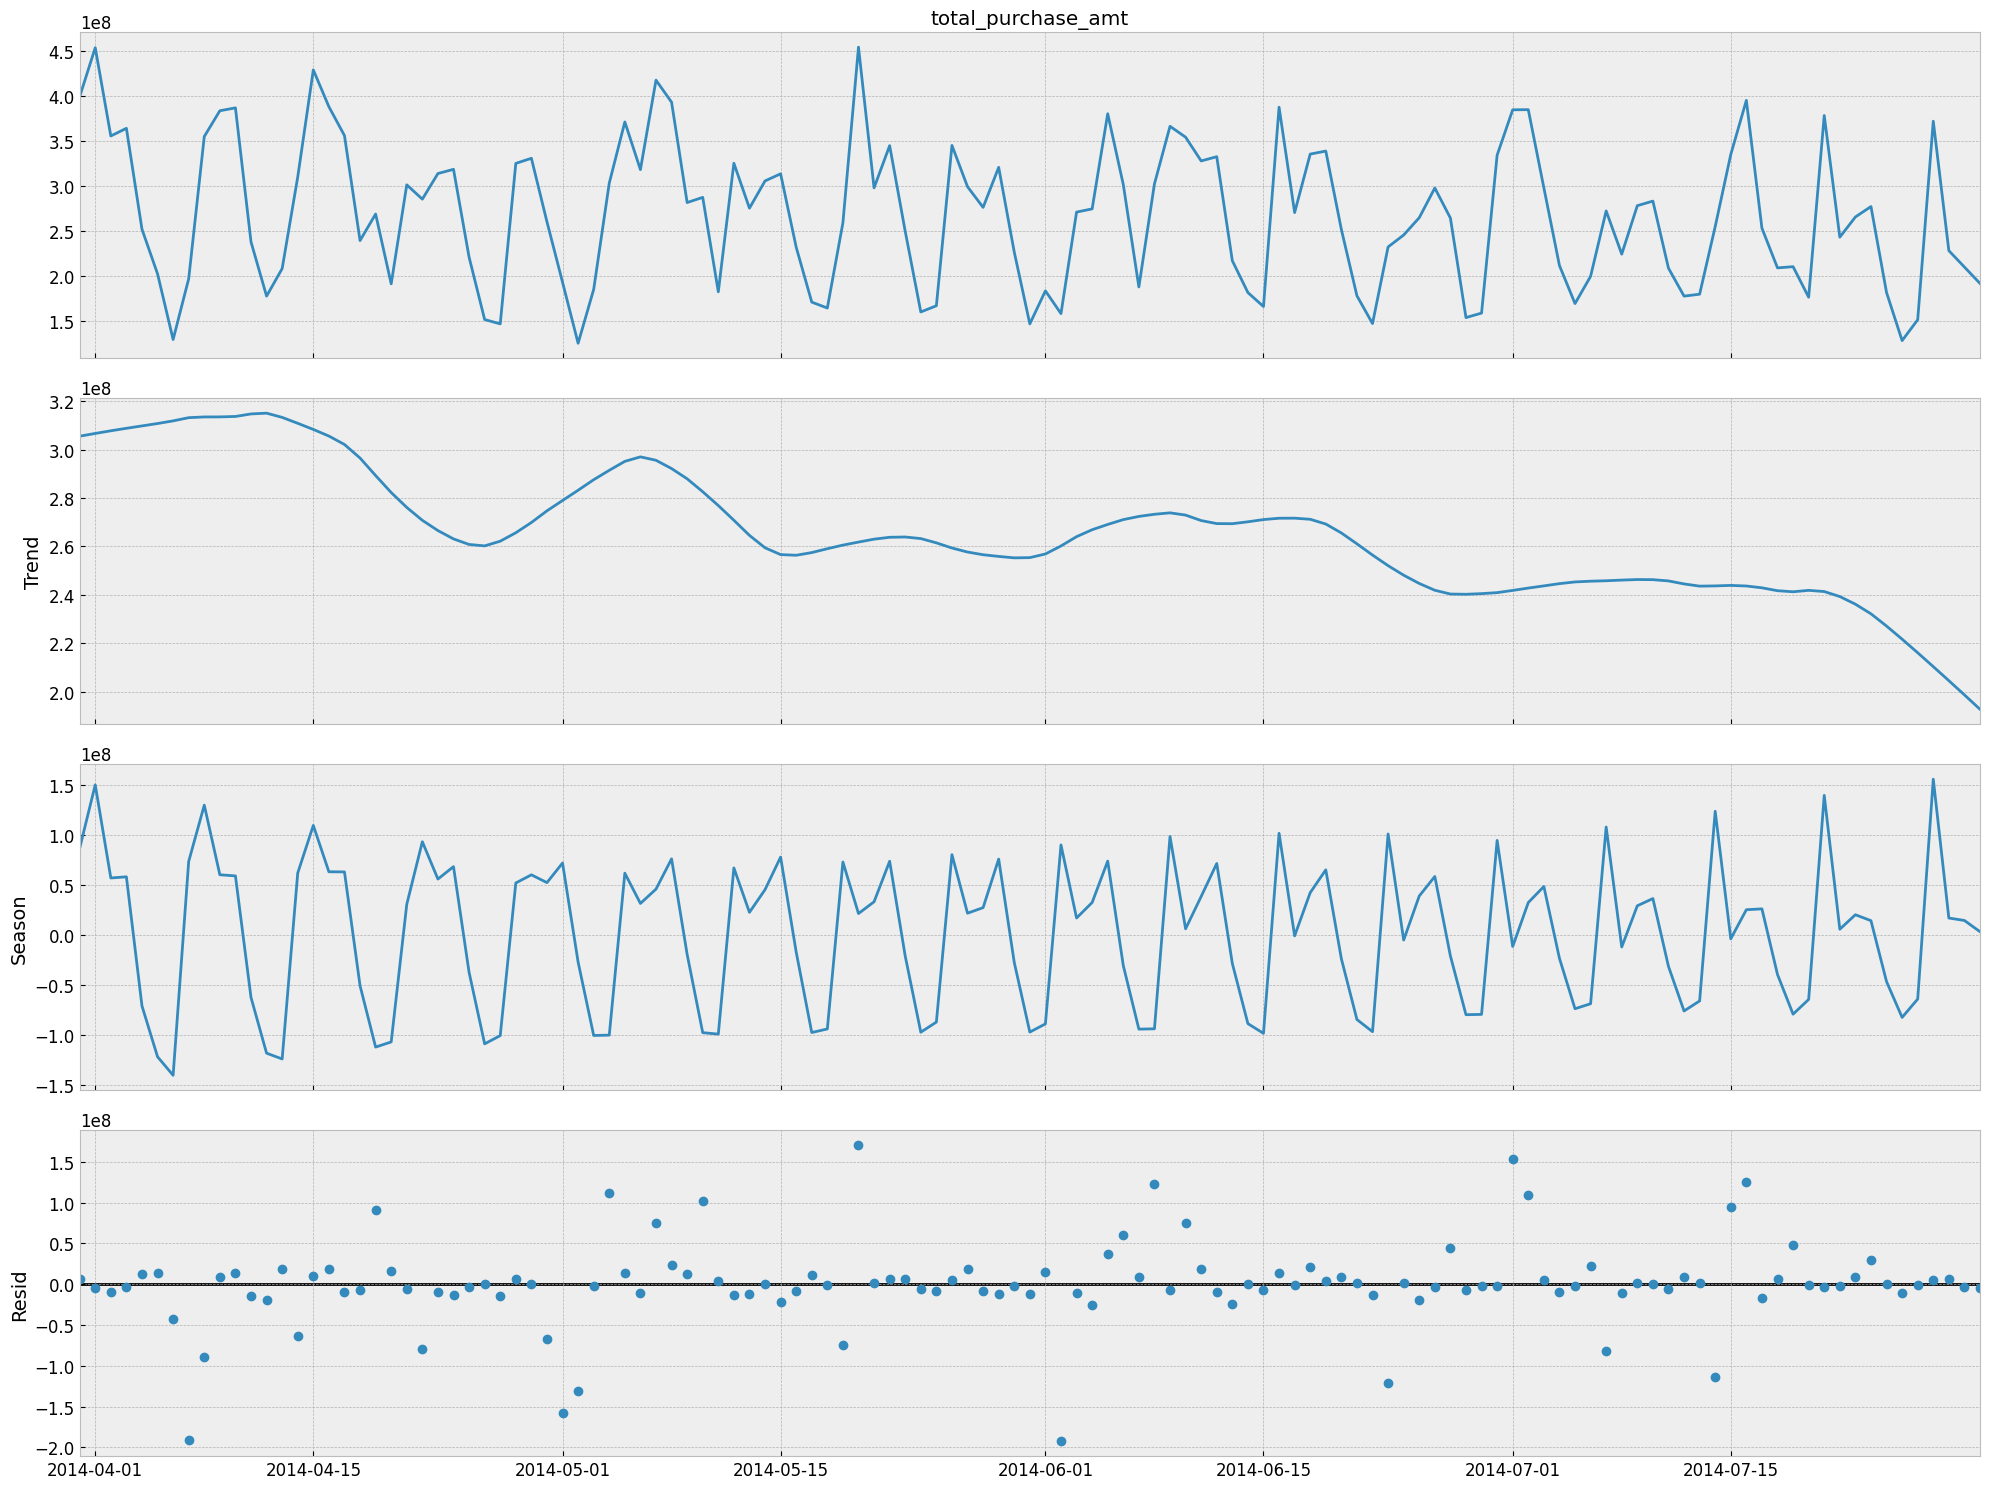

In [16]:
purchase_stl_res = STL(purchase_train,robust = True).fit()
purchase_stl_res.plot()
plt.show()

- Top Panel: This shows the total purchase amount over time, displaying significant variability and some periodic patterns. Peaks and troughs suggest regular fluctuations, which could be tied to specific events or time intervals, such as days of the week, months, or possibly payday cycles.

- Second Panel: The trend line exhibits a slight upward movement followed by a gradual decline, indicating that purchases might be increasing over a period before trending downwards. This could reflect overall consumer behavior changes, marketing impacts, or broader economic factors.

- Third Panel: A clear cyclical patterns are showed in the seasonality, which repeats at regular intervals. The consistency of the seasonality suggests a strong weekly or monthly purchasing cycle, which could correspond to consumer habits or business cycles like end-of-month salary impacts.

- Bottom Panel: The residuals represent the noise or random fluctuations once the trend and seasonality have been accounted for.

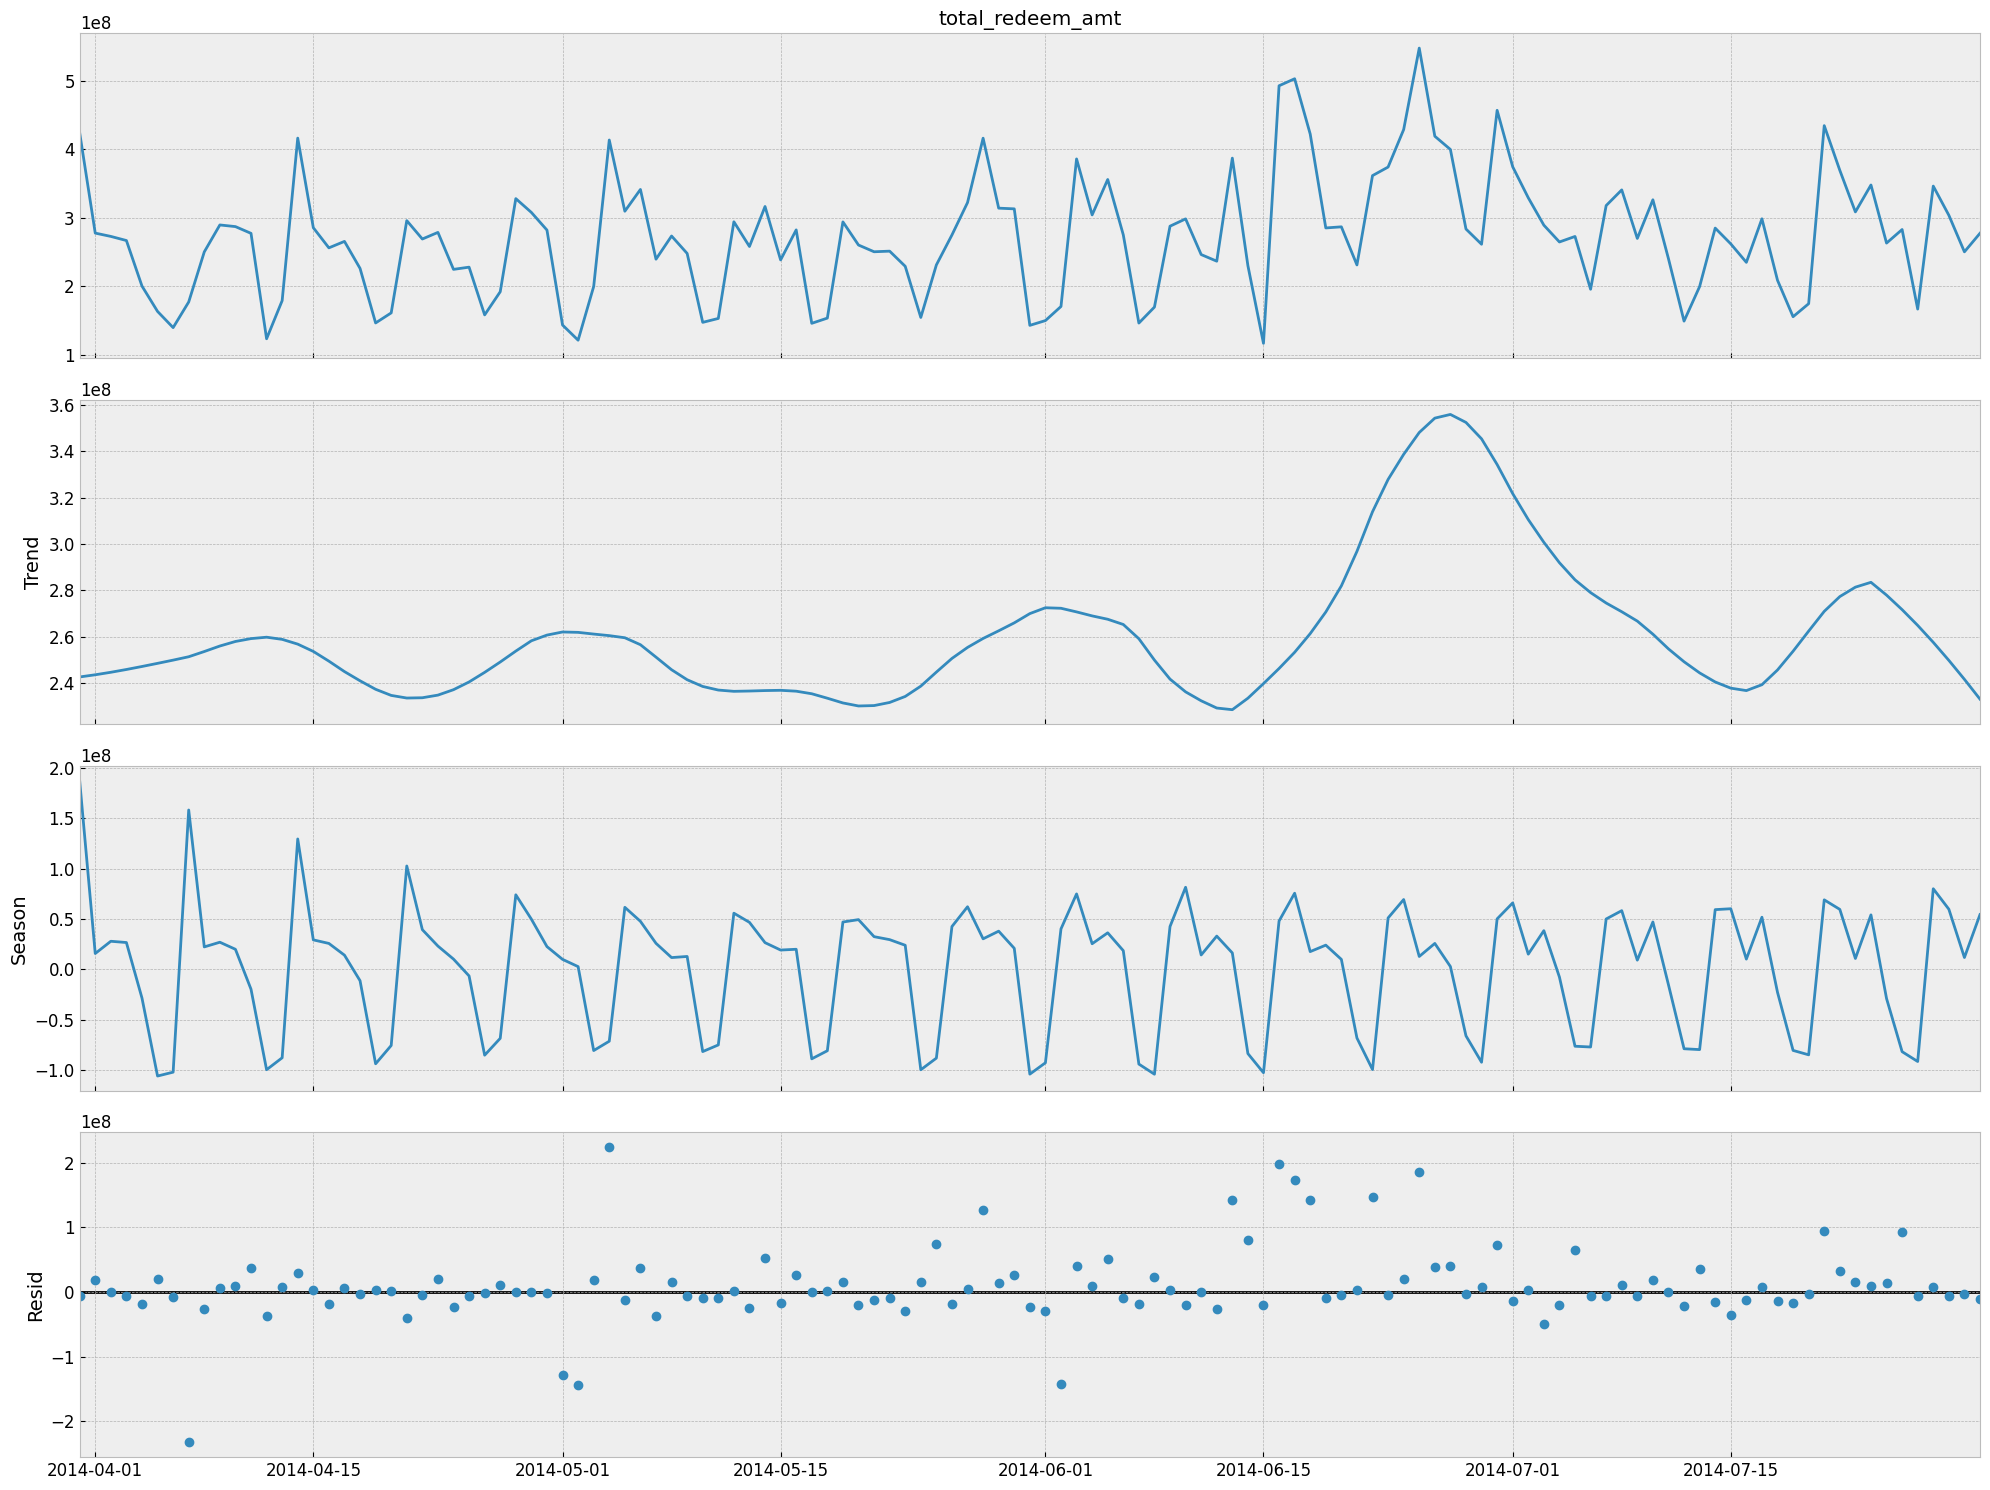

In [21]:
redeem_stl_res = STL(redeem_train,robust = True).fit()
redeem_stl_res.plot()
plt.show()

- Top Panel: The first panel displays the observed time series data, showing the total amount of redemptions over time. The data exhibits variability with peaks and troughs that may correspond to particular events, days, or consumer behavior patterns.

- Second Panel: This trend line shows a noticeable peak around the mid-year mark, which could indicate a seasonal increase in redemption activities during that period.

- Third Panel: The consistent pattern seen here suggests a regular, repeating cycle in redemptions, which could be weekly, bi-weekly, monthly. 

- Bottom Panel: These are the irregularities or 'noise' that remain after removing the trend and seasonal components. Ideally, these should be randomly distributed with no apparent pattern, centered around zero. The distribution of these points gives us an indication of how well the model has captured the underlying patterns. In this plot, the residuals seem to be fairly random and centered, suggesting a good fit of the model to the observed data.


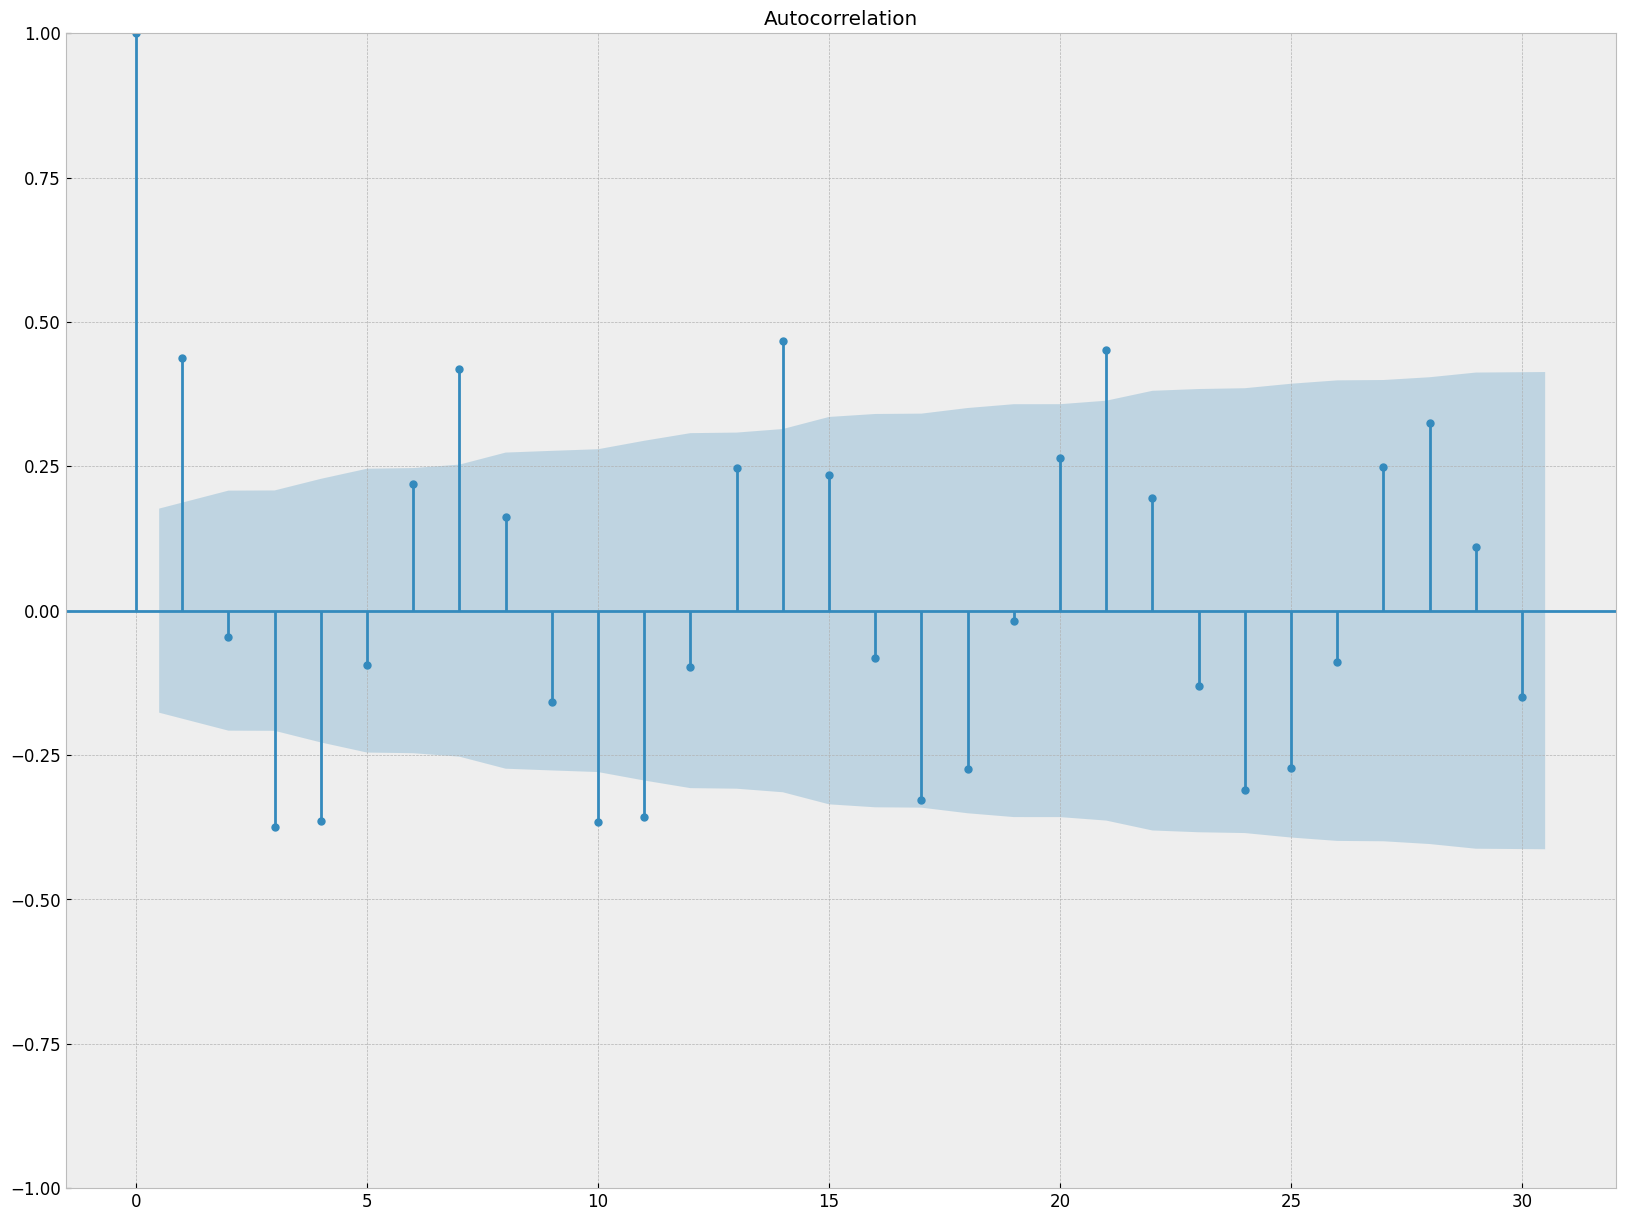

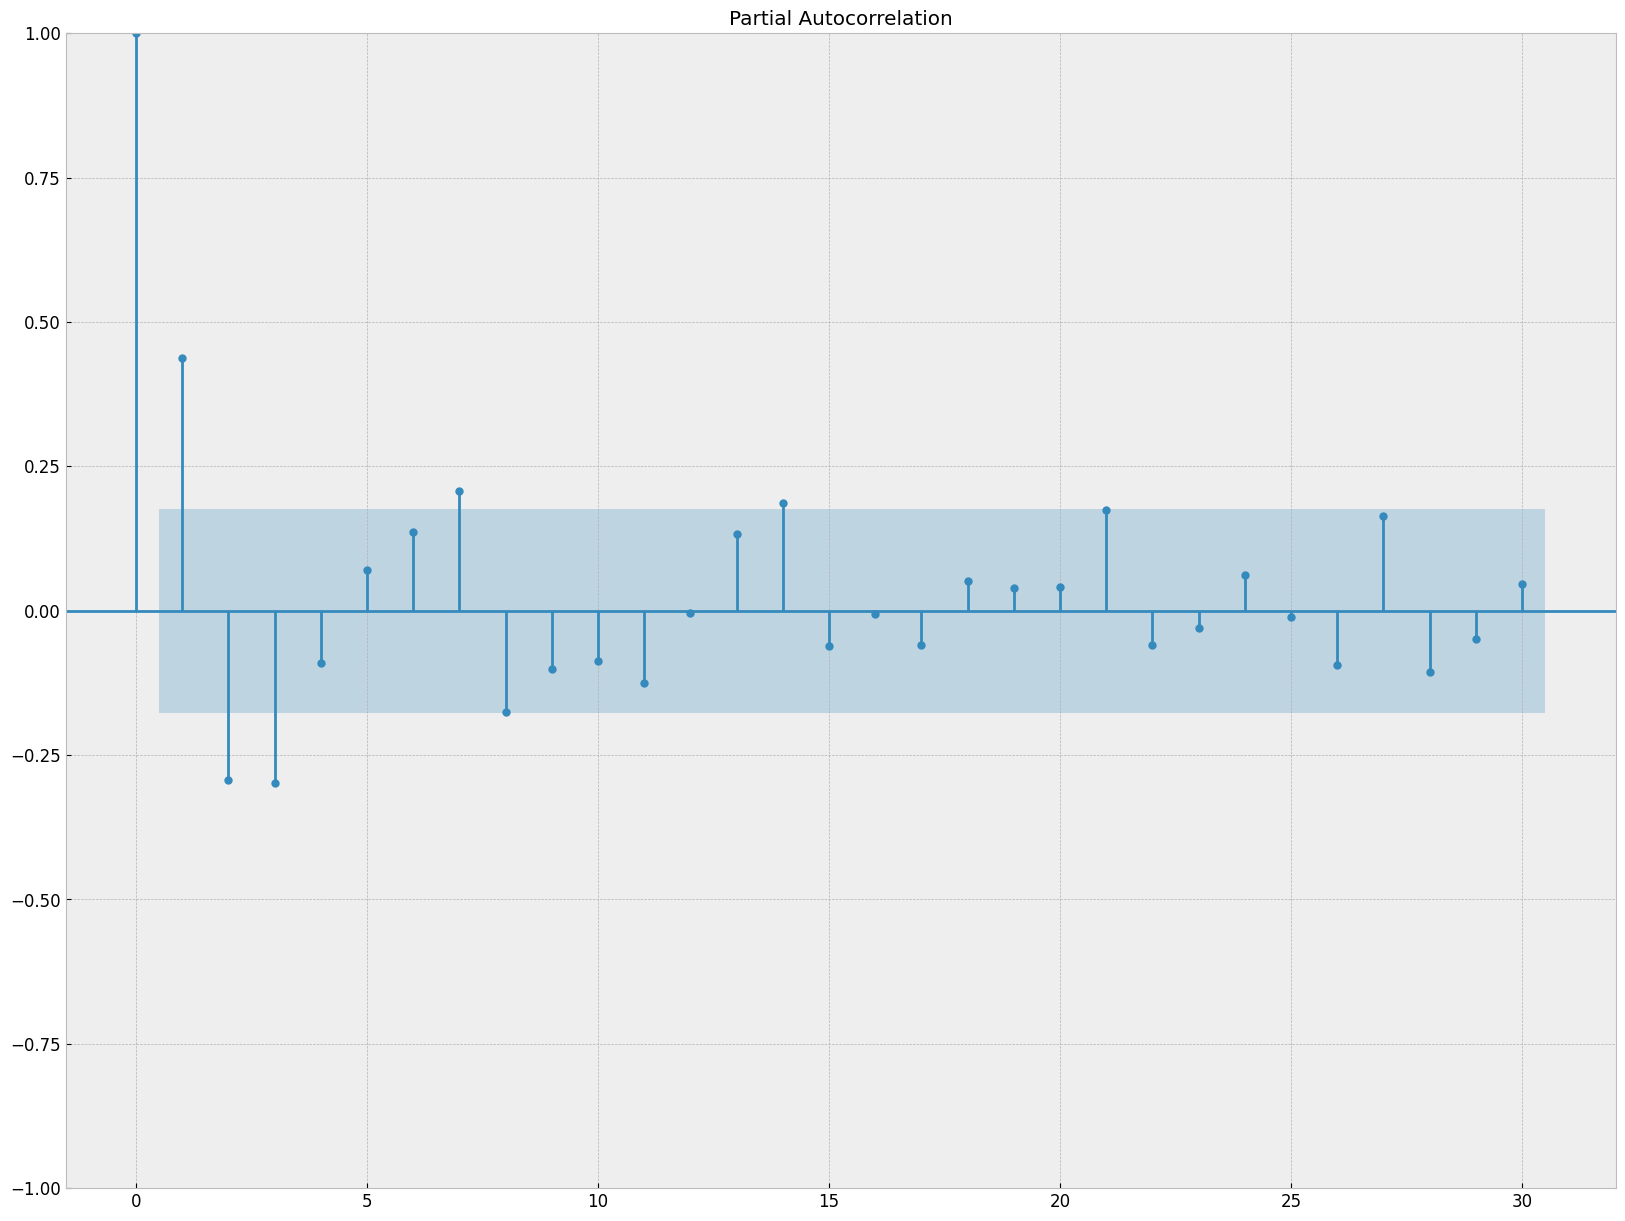

In [22]:
plot_acf(purchase_train, lags=30)
plot_pacf(purchase_train, lags=30)
plt.show()

- Top Plot - Autocorrelation (ACF): The ACF plot shows the correlation of the time series with itself at different lags. A lag is the distance in time between the compared points. The y-axis measures the correlation coefficient, ranging from -1 to 1. A coefficient near 1 indicates a strong positive correlation, while one near -1 indicates a strong negative correlation. The blue shaded area represents the confidence interval, typically at 95%, beyond which correlations are considered statistically significant. In this plot, most autocorrelations outside the immediate lag appear to be within the confidence interval, suggesting that there may not be strong autocorrelation at those lags, or it's not statistically significant.

- The PACF plot shows the partial correlation of the series with itself at different lags, accounting for the values of the time series at shorter lags. This means each bar measures the correlation at that lag, independent of the correlations at all shorter lags. Similar to the ACF plot, the blue shaded area indicates the confidence interval. Bars extending beyond this area suggest a statistically significant partial correlation at that lag. The PACF plot in this image suggests that there are few, if any, significant partial autocorrelations after the first few lags, which is typical for an autoregressive process.


A weekly seasonal pattern (significant partial autocorrelation at every seventh lag) is also observed, so for the baseline prediction, we use data factor to predict the baseline. 

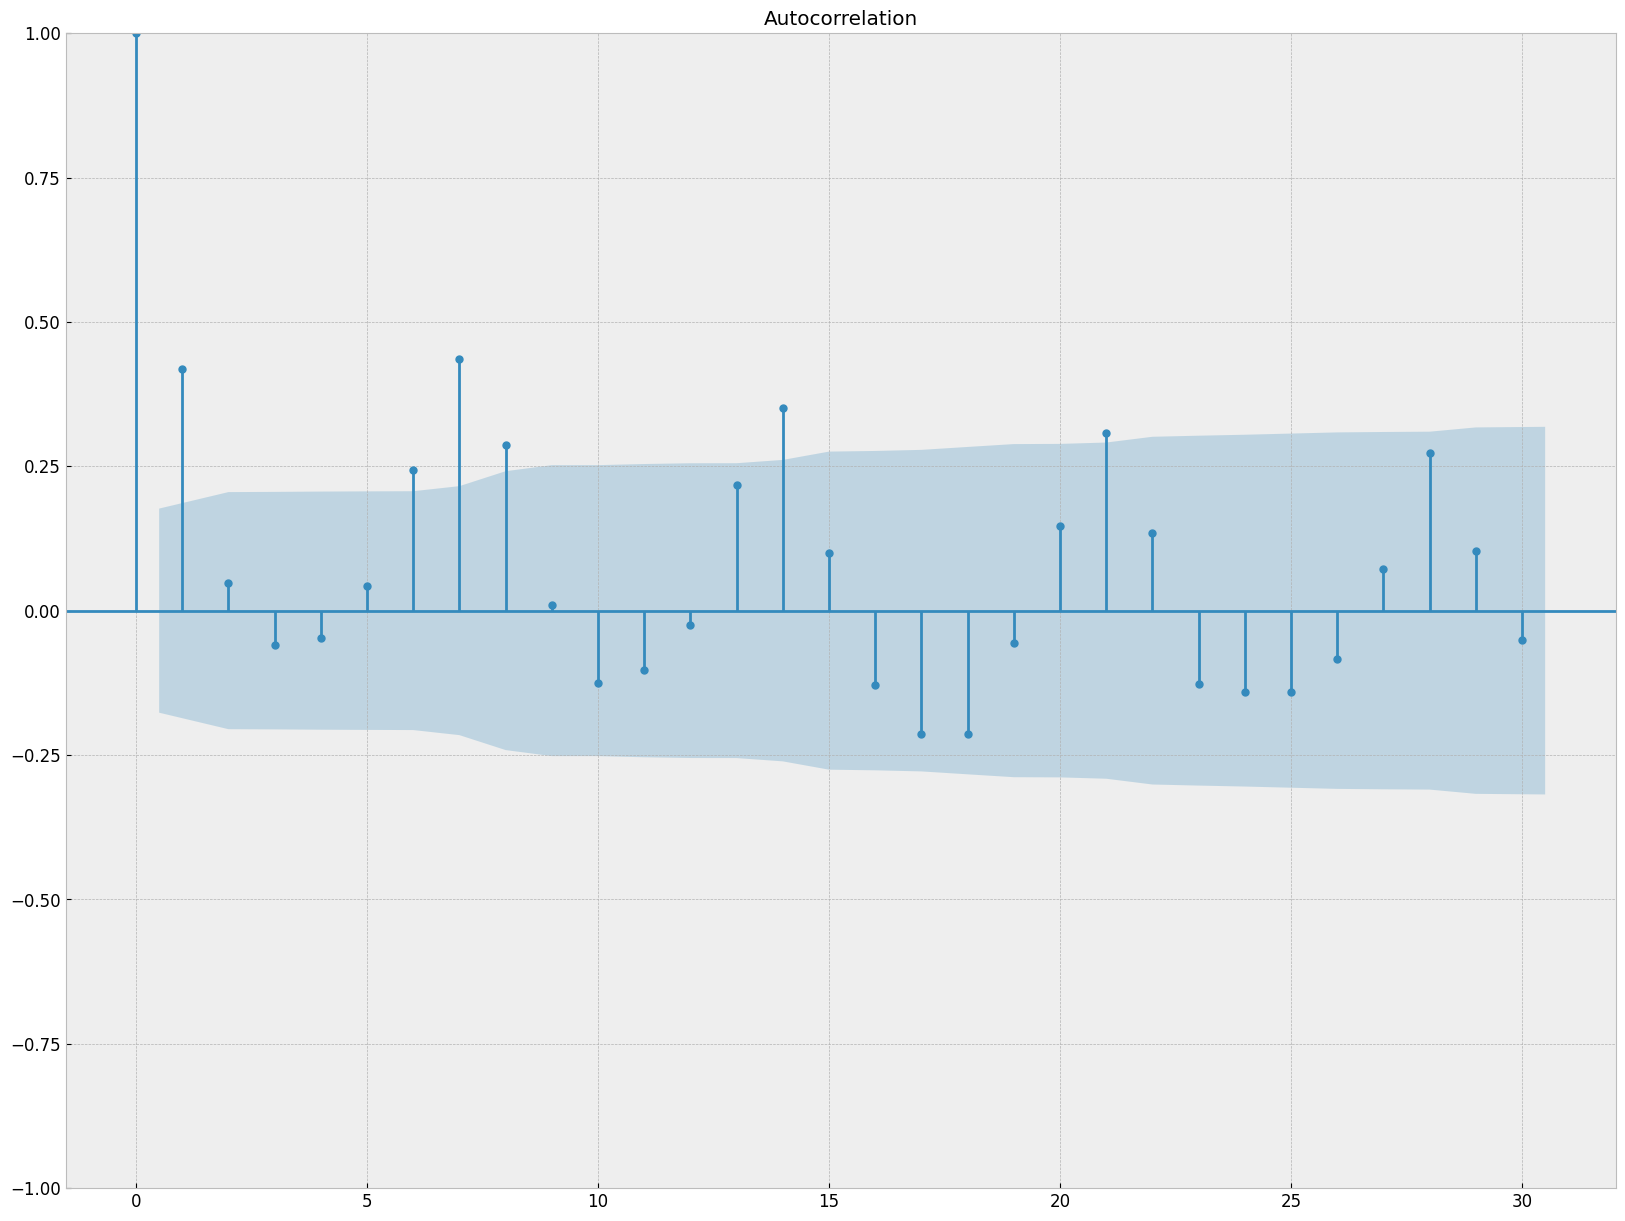

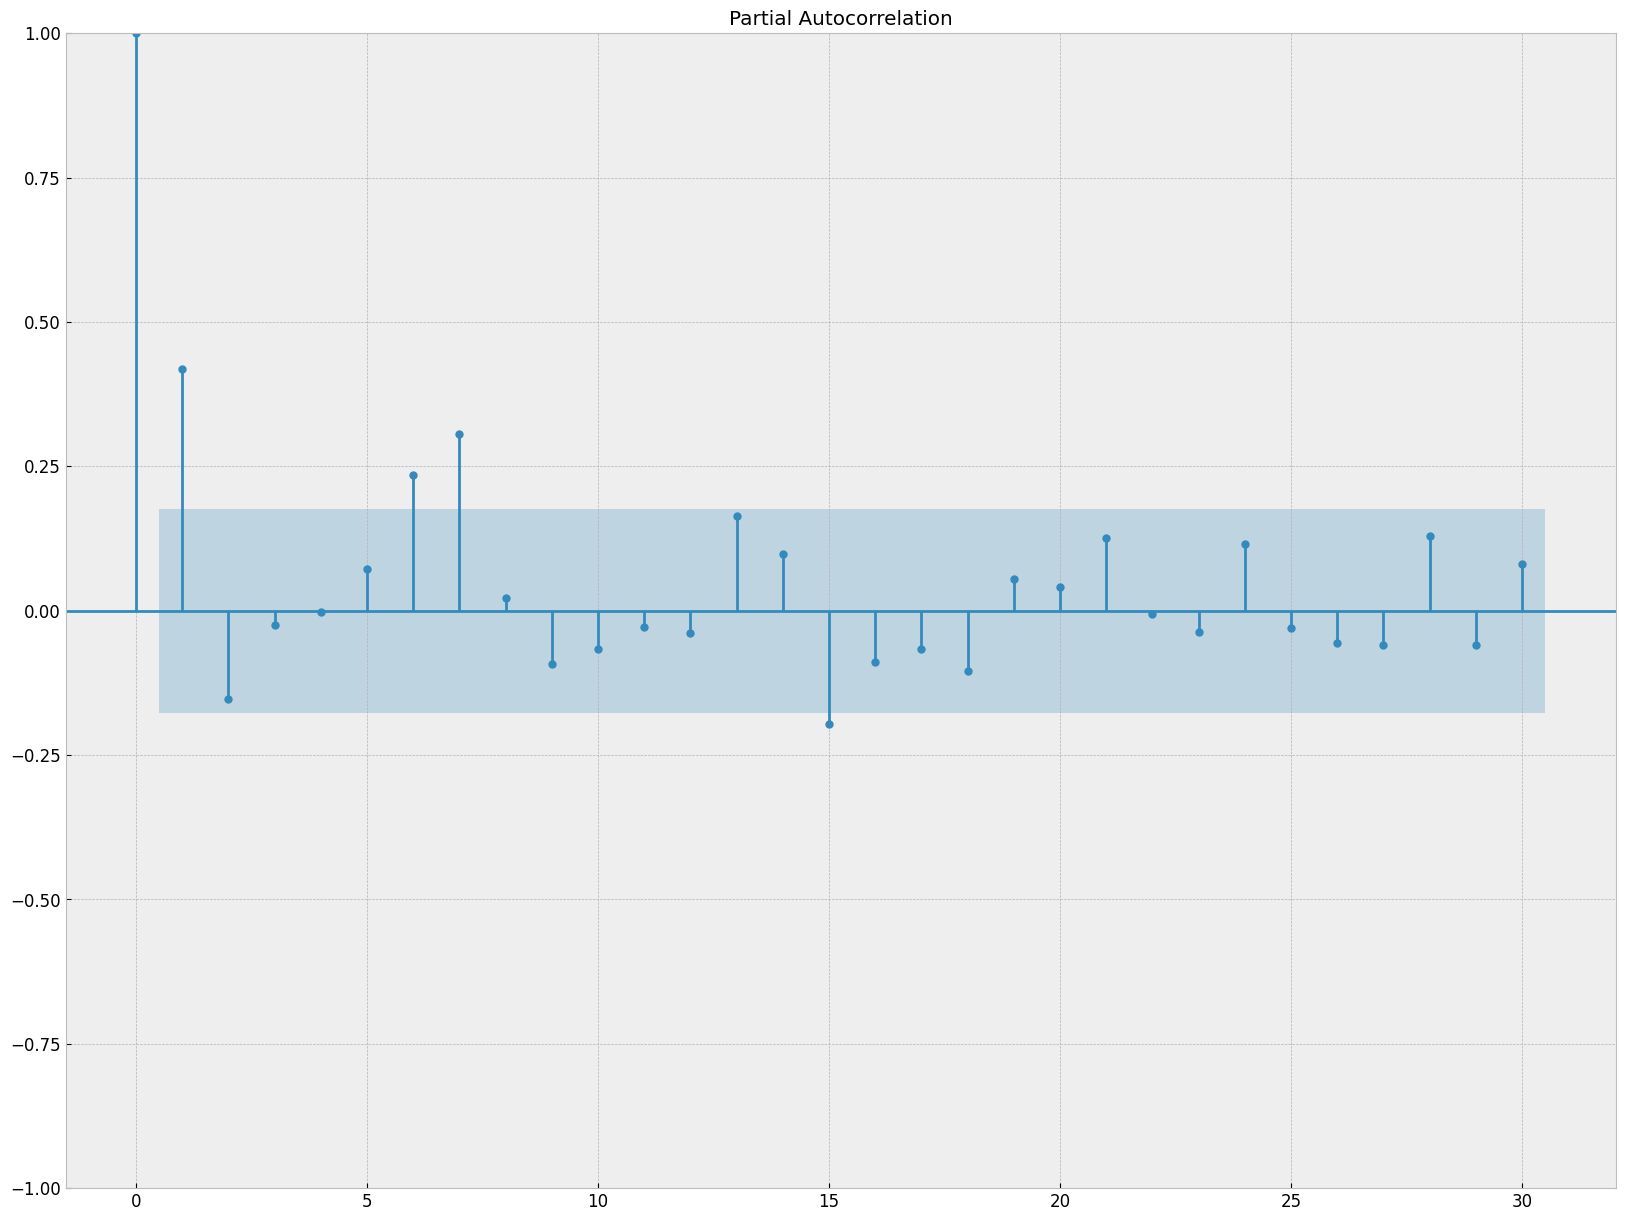

In [23]:
plot_acf(redeem_train, lags=30)
plot_pacf(redeem_train, lags=30)
plt.show()

- ACF plot: In this plot, a few bars are outside of the confidence interval, indicating significant autocorrelations at those lags.
- PACF plot: In this plot, there aren't many lags with bars extending beyond the confidence area, suggesting that there aren't many significant partial autocorrelations.

## Augmented Dickey-Fuller test

We need a robust method to test whether a series is stationary. This is where the ADF test comes in. The Augmented Dickey-Fuller test is a statistical test known as a unit root test. The intuition behind a unit root test is that it determines the strength of the trend that defines a time series. There are many unit root tests, and the Augmented Dickey-Fuller is perhaps one of the more widely used ones. It employs an autoregressive model and optimizes information criteria across multiple different lag values.

In [24]:
X = purchase_train
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.071761
p-value: 0.256020
Critical Values:
	1%: -3.492
	5%: -2.888
	10%: -2.581


Given that the ADF statistic (-2.071761) is higher (less negative) than all the critical values, and the p-value is above the common alpha level of 0.05, this suggests that the null hypothesis of the presence of a unit root cannot be rejected. Therefore, total purchase is likely non-stationary according to this ADF test.

In [25]:
X = redeem_train
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.132040
p-value: 0.231828
Critical Values:
	1%: -3.488
	5%: -2.887
	10%: -2.580


Given that the ADF statistic (-2.132040) is higher (less negative) than all the critical values, and the p-value is above the common alpha level of 0.05, this suggests that the null hypothesis of the presence of a unit root cannot be rejected. Therefore, total redeem is likely non-stationary according to this ADF test.

In [26]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(purchase_train, lags = [7,15,30],boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
7,90.293045,1.077136e-16,86.017254,8.114884e-16
15,181.457528,1.208105e-30,166.848587,1.047909e-27
30,319.169398,4.308319e-50,277.411679,7.170695e-42


In [27]:
acorr_ljungbox(redeem_train, lags = [7,15,30],boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
7,56.190448,8.656632e-10,53.301180,3.232637e-09
15,96.414113,6.214286e-14,89.054892,1.488044e-12
30,157.588523,2.979657e-19,138.338885,7.495336e-16


Given the very small p-values at all tested lags, we can reject the null hypothesis for both the Ljung-Box and Box-Pierce tests, indicating that the residuals of your model exhibit significant autocorrelation and are not random

# ARIMA

ARIMA works by creating a linear regression model with the specified parameters. It will prepare the data by applying a degree of differencing in order to make the data stationary. This will remove any trend or seasonality that will reduce the accuracy of the regression model.

In order to fit an ARIMA model, we will need to specify the p, d, and q model parameters.

A value of **0** can be used for any of the parameters. This will remove that process from the model construction. 

**p** - The number of lag observations included in the model, also called lag order. 

**d** - The number of times the raw observations are differenced, also called degree of differencing. 

**q** - The size of the moving average window, also called the order of the moving average. 

I have determined that our data is **non-stationary**. Our goal is to adjust the **p**, **d**, **q**, in order to make the time series stationary. Once, a time series has been made stationary, a model is able to capture the unique patterns and them apply **trend** and **seasonal** patterns later. 





In [28]:
from statsmodels.tsa.arima.model import ARIMA

In [29]:
# Evaluate an ARIMA model for a given order (p, d, q)
def evaluate_arima_model(train, test, arima_order):
    history = [x for x in train]
    predictions=[]
    for t in range(len(test)):
        model=ARIMA(history,order=arima_order)
        model_fit=model.fit()
        yhat=model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
        
    # Calculate MAPE
    actual = np.array(test)
    predictions = np.array(predictions)
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100  # Calculate MAPE as a percentage
    
    return mape

From previous autocorrelation grapj, We can set lag value to 2 for autogression, uses a difference order of 1 in an attempt to make the time series stationary, and uses a mover average model of 0. 

In [30]:
arima_order=(2,3,0)

In [31]:
mape=evaluate_arima_model(purchase_train,purchase_test,arima_order)
mape

51.16838165483595

## Utilizing grid search

Using a grid search, we can iterate through a defined list of possible ARIMA parameters, build a model for each one, and find the best performance


In [32]:
def grid_search(p_values,d_values,q_values,purchase_ts,purchase_true):
    score,best_ARIMA_config=float("inf"),None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order=(p,d,q)
                try:
                    mape=evaluate_arima_model(purchase_ts,purchase_true,order)
                    if mape<score:
                        score,best_ARIMA_config=mape,order
                    print('ARIMA{} mape={:.3f}'.format(order, mape))
                except:
                    continue
                    
    print('Best ARIMA{} MAPE={:.3f}'.format(best_ARIMA_config, score))
                        

                        
        
        

In [33]:
p_values = [0, 1, 2, 3, 4, 5]
d_values = range(0, 3)
q_values = range(0, 3)

In [34]:
grid_search(p_values,d_values,q_values,purchase_train,purchase_test)

ARIMA(0, 0, 0) mape=23.734
ARIMA(0, 0, 1) mape=23.888
ARIMA(0, 0, 2) mape=24.237
ARIMA(0, 1, 0) mape=26.272
ARIMA(0, 1, 1) mape=26.813
ARIMA(0, 1, 2) mape=23.603
ARIMA(0, 2, 0) mape=44.839
ARIMA(0, 2, 1) mape=26.632
ARIMA(0, 2, 2) mape=26.876
ARIMA(1, 0, 0) mape=24.411
ARIMA(1, 0, 1) mape=24.165
ARIMA(1, 0, 2) mape=24.165
ARIMA(1, 1, 0) mape=26.551
ARIMA(1, 1, 1) mape=24.049
ARIMA(1, 1, 2) mape=23.869
ARIMA(1, 2, 0) mape=34.645
ARIMA(1, 2, 1) mape=26.726
ARIMA(1, 2, 2) mape=26.405
ARIMA(2, 0, 0) mape=23.898
ARIMA(2, 0, 1) mape=23.705
ARIMA(2, 0, 2) mape=18.743
ARIMA(2, 1, 0) mape=26.608
ARIMA(2, 1, 1) mape=23.302
ARIMA(2, 1, 2) mape=22.628
ARIMA(2, 2, 0) mape=33.701
ARIMA(2, 2, 1) mape=27.066
ARIMA(2, 2, 2) mape=26.459
ARIMA(3, 0, 0) mape=24.354
ARIMA(3, 0, 1) mape=24.250
ARIMA(3, 0, 2) mape=20.378
ARIMA(3, 1, 0) mape=25.530
ARIMA(3, 1, 1) mape=23.142
ARIMA(3, 1, 2) mape=23.788
ARIMA(3, 2, 0) mape=30.481
ARIMA(3, 2, 1) mape=26.107
ARIMA(3, 2, 2) mape=23.479
ARIMA(4, 0, 0) mape=24.440
A

In [35]:
grid_search(p_values,d_values,q_values,redeem_train,redeem_test)

ARIMA(0, 0, 0) mape=28.129
ARIMA(0, 0, 1) mape=28.279
ARIMA(0, 0, 2) mape=27.262
ARIMA(0, 1, 0) mape=29.313
ARIMA(0, 1, 1) mape=26.364
ARIMA(0, 1, 2) mape=27.158
ARIMA(0, 2, 0) mape=52.497
ARIMA(0, 2, 1) mape=29.669
ARIMA(0, 2, 2) mape=26.243
ARIMA(1, 0, 0) mape=26.135
ARIMA(1, 0, 1) mape=27.537
ARIMA(1, 0, 2) mape=27.159
ARIMA(1, 1, 0) mape=26.741
ARIMA(1, 1, 1) mape=26.104
ARIMA(1, 1, 2) mape=27.036
ARIMA(1, 2, 0) mape=35.956
ARIMA(1, 2, 1) mape=27.882
ARIMA(1, 2, 2) mape=30.036
ARIMA(2, 0, 0) mape=27.652
ARIMA(2, 0, 1) mape=27.540
ARIMA(2, 0, 2) mape=27.442
ARIMA(2, 1, 0) mape=27.834
ARIMA(2, 1, 1) mape=26.963
ARIMA(2, 1, 2) mape=28.907
ARIMA(2, 2, 0) mape=36.401
ARIMA(2, 2, 1) mape=29.058
ARIMA(2, 2, 2) mape=27.213
ARIMA(3, 0, 0) mape=27.429
ARIMA(3, 0, 1) mape=27.462
ARIMA(3, 0, 2) mape=26.895
ARIMA(3, 1, 0) mape=27.081
ARIMA(3, 1, 1) mape=25.441
ARIMA(3, 1, 2) mape=26.026
ARIMA(3, 2, 0) mape=32.863
ARIMA(3, 2, 1) mape=27.898
ARIMA(4, 0, 0) mape=27.482
ARIMA(4, 0, 1) mape=27.511
A

In [36]:
purchase_history=[x for x in purchase_train]
purchase_predictions=[]

for t in range(len(purchase_test)):
    model = ARIMA(purchase_history, order=(2,0,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    y_pred = output[0]
    purchase_predictions.append(y_pred)
    purchase_history.append(y_pred)

In [37]:
purchase_predictions = np.array(purchase_predictions)
purchase_test_np=np.array(purchase_test)


In [32]:
purchase_predictions

array([2.19482438e+08, 1.93477222e+08, 2.22943285e+08, 2.85548547e+08,
       3.34046143e+08, 3.31776351e+08, 2.80705118e+08, 2.19154580e+08,
       1.93649778e+08, 2.23452956e+08, 2.86087288e+08, 3.34303548e+08,
       3.31667363e+08, 2.80164321e+08, 2.18718897e+08, 1.93760503e+08,
       2.23948092e+08, 2.86676359e+08, 3.34515349e+08, 3.31377472e+08,
       2.79833118e+08, 2.18286257e+08, 1.93469618e+08, 2.24059364e+08,
       2.87099444e+08, 3.34914764e+08, 3.31409365e+08, 2.79240415e+08,
       2.17819924e+08, 1.93519513e+08, 2.24627885e+08])

In [33]:
purchase_test_np

array([374884735, 189092130, 173825397, 330640884, 394780870, 288821016,
       247646474, 233903717, 160262764, 259534870, 331550471, 258493673,
       261506619, 257702660, 244551620, 215059736, 149978271, 298499146,
       266401973, 308378692, 251763517, 246316056, 141412027, 130195484,
       309574223, 306945089, 302194801, 245082751, 267554713, 199708772,
       275090213])

In [34]:
redeem_history=[x for x in redeem_train]
redeem_predictions=[]

for t in range(len(redeem_test)):
    model = ARIMA(redeem_history, order=(5,1,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    y_pred = output[0]
    redeem_predictions.append(y_pred)
    redeem_history.append(y_pred)

In [35]:
redeem_predictions

[232537564.77367562,
 186693494.0884802,
 200904403.75195608,
 265082220.66431218,
 303608898.2320343,
 300766334.7110264,
 260620213.56730026,
 214633385.94628188,
 191612969.46013474,
 207719841.51990435,
 257350786.7615076,
 298403982.28477407,
 299747017.3333476,
 262800739.43570885,
 212574938.30045518,
 186743921.99840108,
 204466177.93440032,
 251969821.93528718,
 296199370.03972566,
 300780630.23093235,
 263181887.35115328,
 211031052.3758765,
 184726055.4943681,
 204275506.30136073,
 250609716.2146662,
 294530844.1882555,
 300940533.9718256,
 263506934.3801997,
 212009314.91712618,
 189337212.2771141,
 203065206.1999592]

In [36]:
redeem_predictions = np.array(redeem_predictions)
redeem_test_np=np.array(redeem_test)


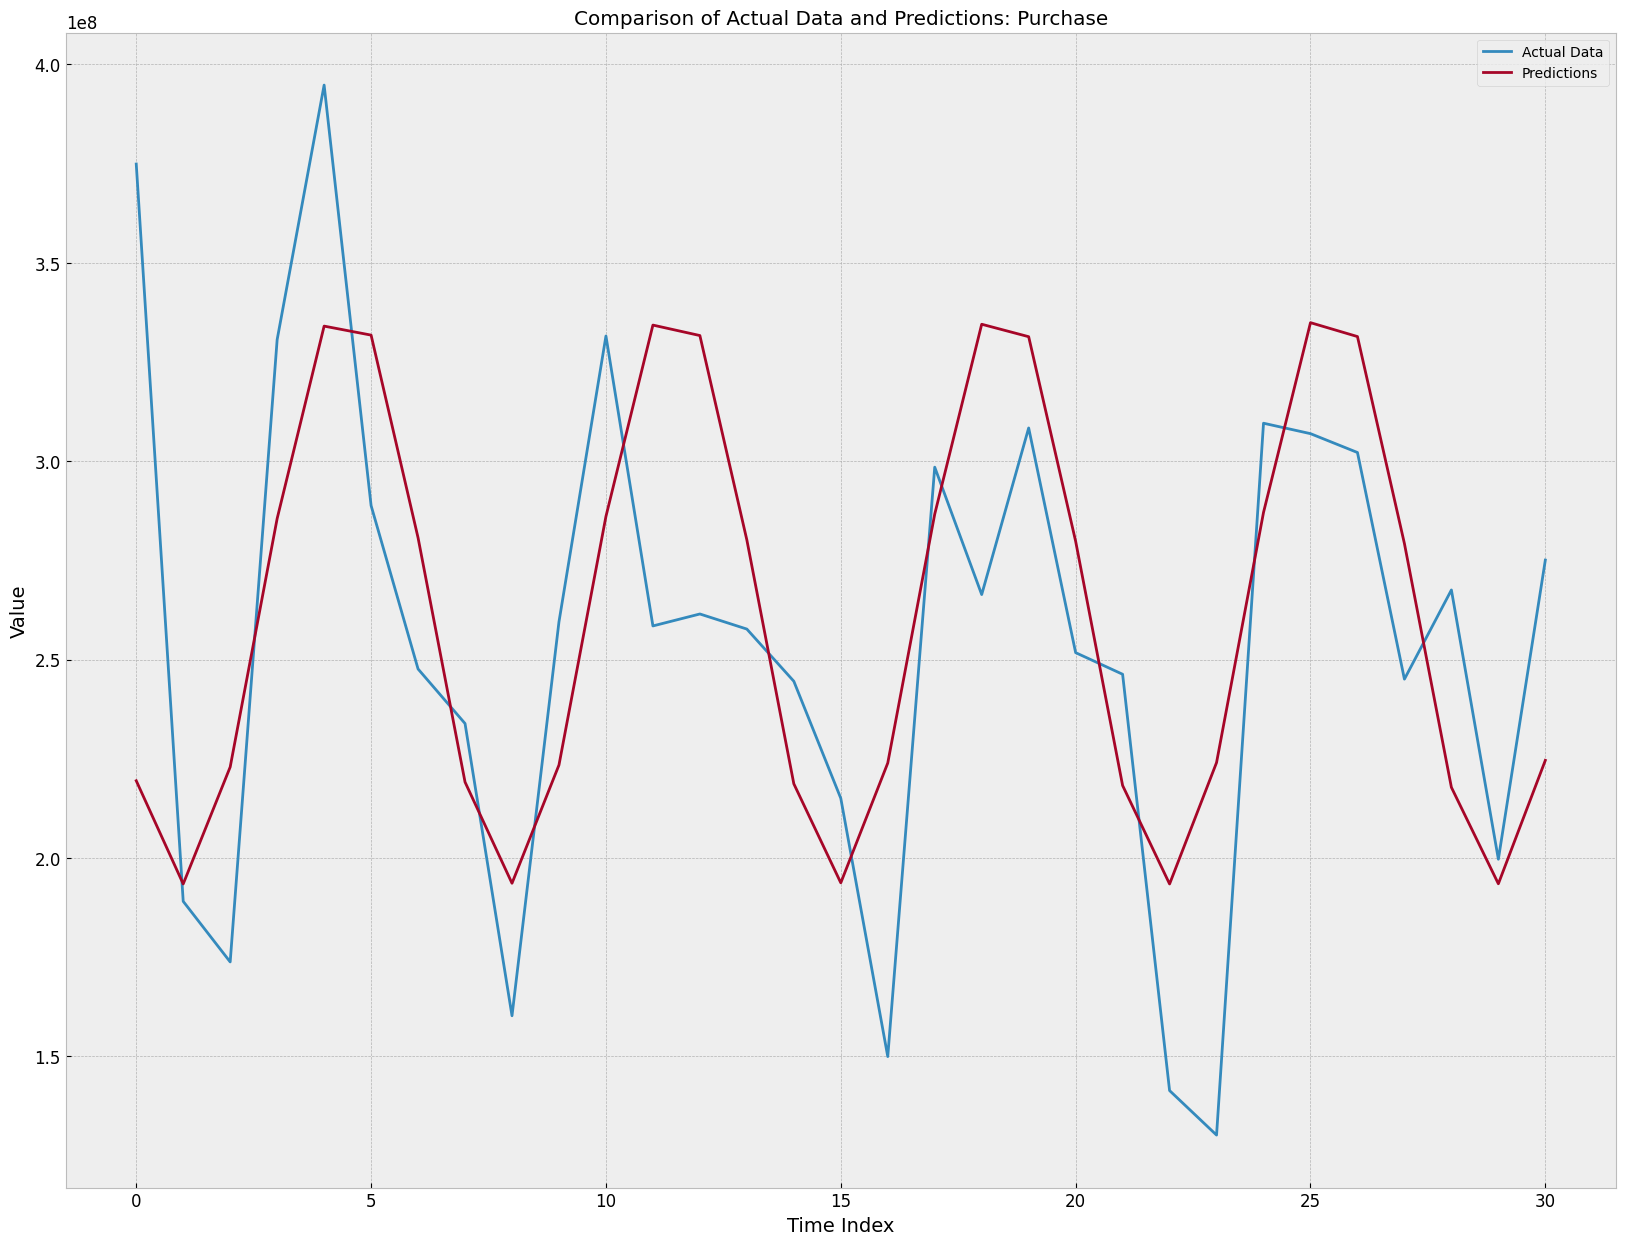

In [37]:
plt.plot(purchase_test_np, label='Actual Data') 
plt.plot(purchase_predictions, label='Predictions')
plt.title('Comparison of Actual Data and Predictions: Purchase')
plt.xlabel('Time Index')
plt.ylabel('Value')
plt.legend()
plt.show() 

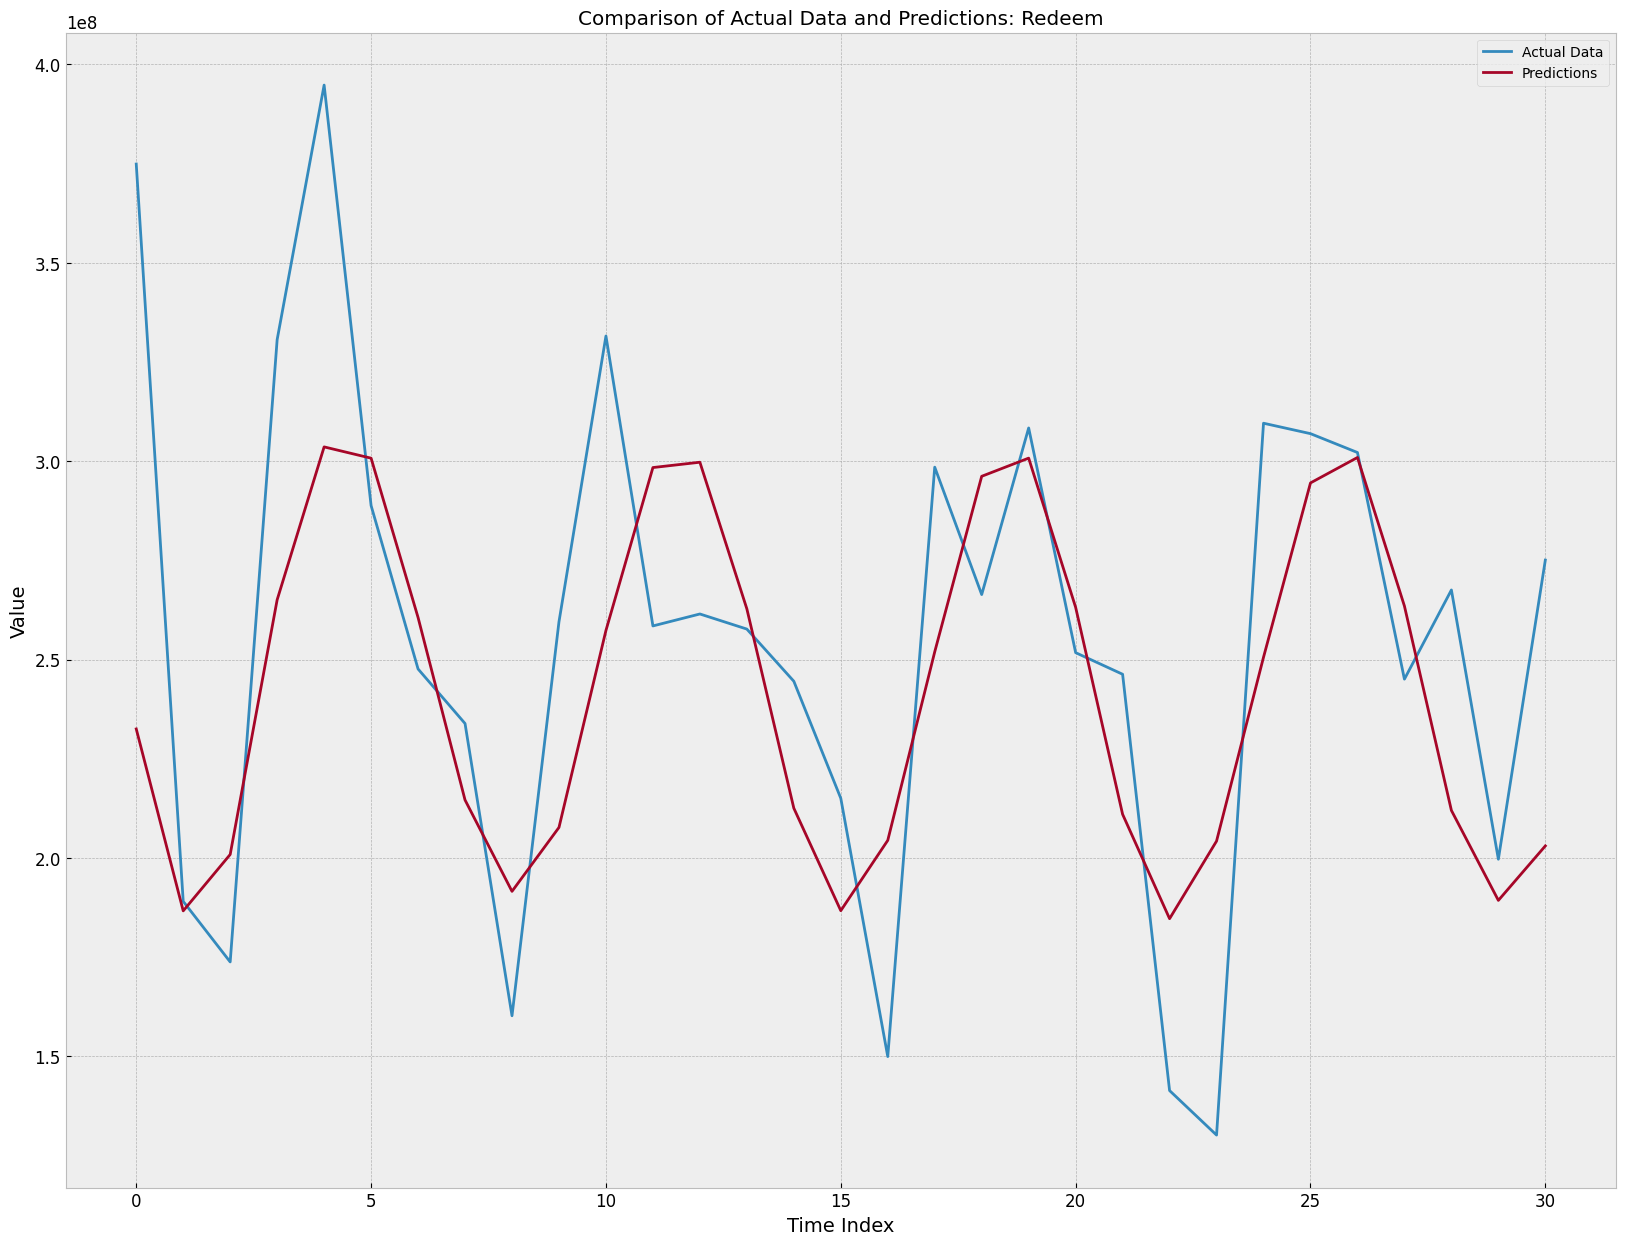

In [38]:
plt.plot(purchase_test_np, label='Actual Data') 
plt.plot(redeem_predictions, label='Predictions')
plt.title('Comparison of Actual Data and Predictions: Redeem')
plt.xlabel('Time Index')
plt.ylabel('Value')
plt.legend()
plt.show() 

## Use ARIMA to predict from September 1 to September 30, 2014

In [39]:
purchase_history = pd.concat([purchase_train, purchase_test])

purchase_history=[x for x in purchase_history]
purchase_predictions_Sep=[]

for t in range(len(baseline_prediction)):
    model = ARIMA(purchase_history, order=(2,0,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    y_pred = output[0]
    purchase_predictions_Sep.append(y_pred)
    purchase_history.append(y_pred)

In [40]:
redeem_history = pd.concat([redeem_train, redeem_test])

redeem_history=[x for x in redeem_history]
redeem_predictions_Sep=[]

for t in range(len(baseline_prediction)):
    model = ARIMA(redeem_history, order=(5,1,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    y_pred = output[0]
    redeem_predictions_Sep.append(y_pred)
    redeem_history.append(y_pred)

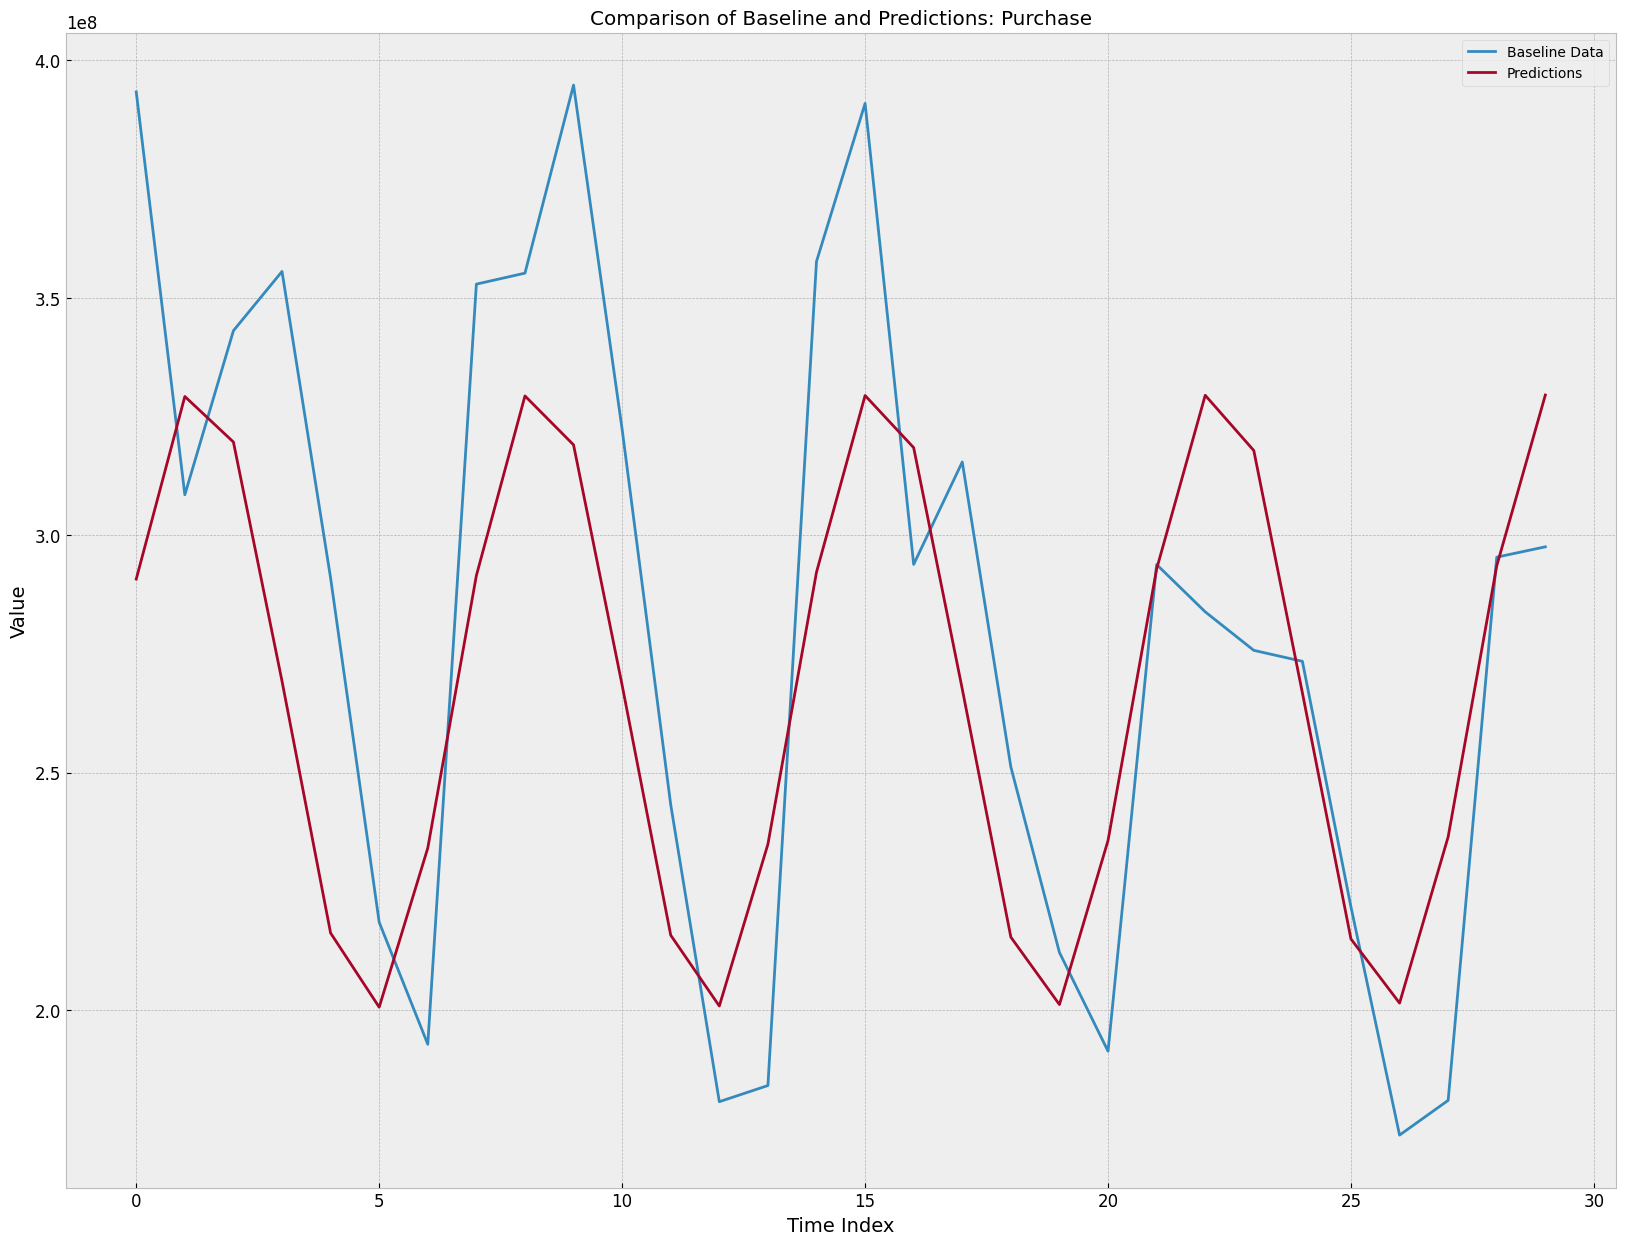

In [41]:
plt.plot(baseline_prediction['total_purchase_amt_base'], label='Baseline Data') 
plt.plot(purchase_predictions_Sep, label='Predictions')
plt.title('Comparison of Baseline and Predictions: Purchase')
plt.xlabel('Time Index')
plt.ylabel('Value')
plt.legend()
plt.show() 

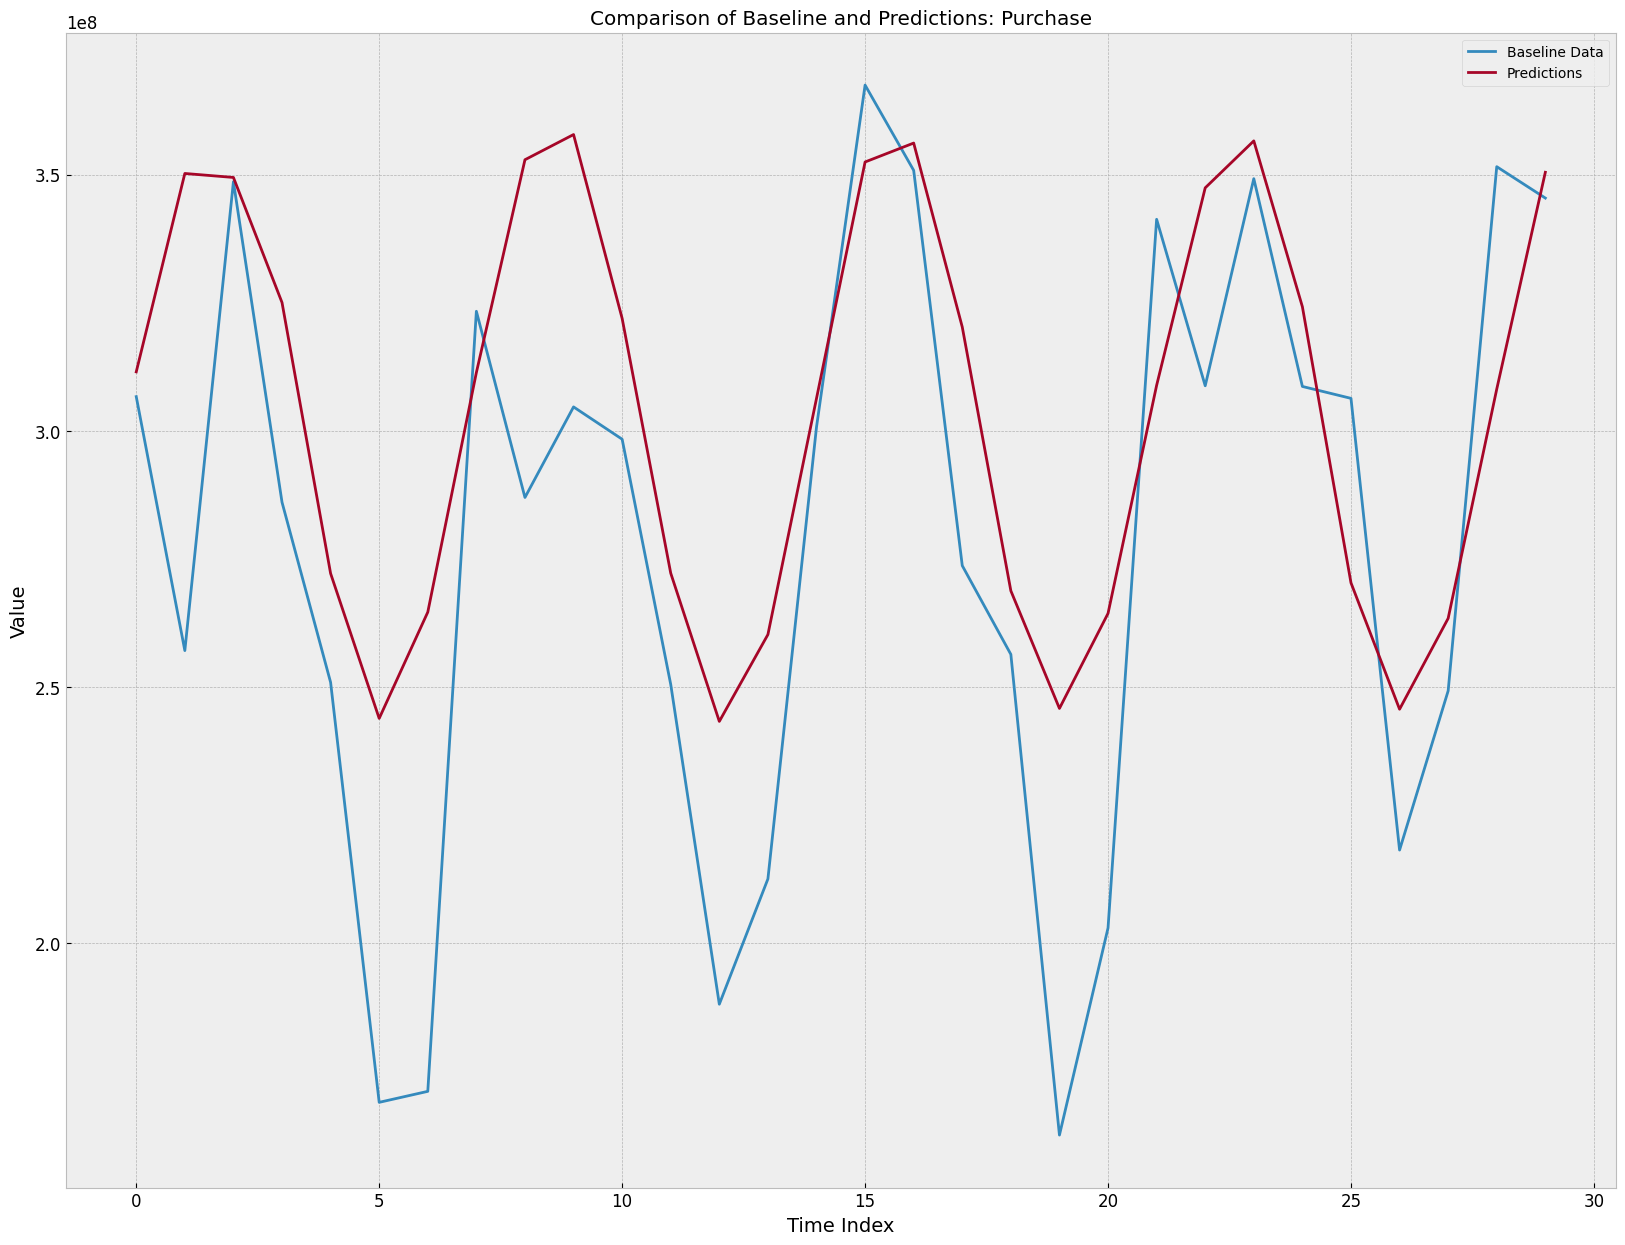

In [42]:
plt.plot(baseline_prediction['total_redeem_amt_base'], label='Baseline Data') 
plt.plot(redeem_predictions_Sep, label='Predictions')
plt.title('Comparison of Baseline and Predictions: Purchase')
plt.xlabel('Time Index')
plt.ylabel('Value')
plt.legend()
plt.show() 